In [28]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
train_data = '/home/gautham/EyesOnTheRoad/all/imgs/train'
test_path = '/home/gautham/EyesOnTheRoad/all/imgs/test'
experiment_name = 'DistractedDriving_Model1'
history_save_as = 'history_10Epochs_'+experiment_name
model_save_as = '10Epochs_'+experiment_name

In [38]:
# dimensions of our images.
img_width, img_height = 128, 96
nb_train_samples = 16822
nb_validation_samples = 5602
epochs = 5
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   validation_split=0.25)

#For training we use the train_datagen, while valid and test we use default

train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='training')

validation_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    class_mode='categorical',    
    batch_size=batch_size,
    subset='validation')

Found 16822 images belonging to 10 classes.
Found 5602 images belonging to 10 classes.


In [39]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
          
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))


In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [41]:
import pickle

history = model.fit_generator(
    train_batches,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_batches,
    validation_steps=nb_validation_samples // batch_size)

model.save(model_save_as+'.h5')

history_out = open(history_save_as+'.pickle', "wb")
pickle.dump(history.history, history_out)
history_out.close()

Epoch 1/5
262/262 [==============================] - 397s 2s/step - loss: 1.2212 - acc: 0.5815 - val_loss: 0.1512 - val_acc: 0.9648
Epoch 2/5
262/262 [==============================] - 310s 1s/step - loss: 0.2615 - acc: 0.9185 - val_loss: 0.0559 - val_acc: 0.9859
Epoch 3/5
262/262 [==============================] - 308s 1s/step - loss: 0.1407 - acc: 0.9560 - val_loss: 0.0331 - val_acc: 0.9927
Epoch 4/5
262/262 [==============================] - 303s 1s/step - loss: 0.0943 - acc: 0.9692 - val_loss: 0.0268 - val_acc: 0.9936
Epoch 5/5
262/262 [==============================] - 307s 1s/step - loss: 0.0767 - acc: 0.9738 - val_loss: 0.0235 - val_acc: 0.9946


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


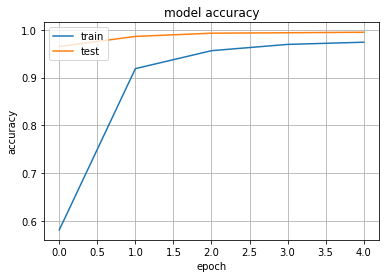

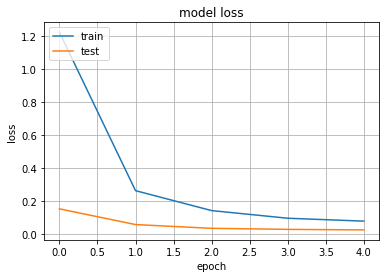

In [42]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.savefig("graph_acc_10Epochs_"+experiment_name+".png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.savefig("graph_loss_10Epochs_"+experiment_name+".png")
plt.show()

In [43]:
import pickle
def pickleLoader(pklFile):
    try:
        while True:
            yield pickle.load(pklFile)
    except EOFError:
        print("EOF")
        pass

with open(history_save_as+'.pickle', "rb") as f:
    for event in pickleLoader(f):
        print(event)

{'val_loss': [0.15118997700190553, 0.0559472100851111, 0.03314417905996459, 0.026793233931536292, 0.023499260042871853], 'val_acc': [0.9648339876912398, 0.9858978936094253, 0.9926811852909675, 0.9935737236701179, 0.9946447697250982], 'loss': [1.2215873787206488, 0.26146244009335834, 0.14063211954860674, 0.09432373740030638, 0.07670780445129721], 'acc': [0.5813342880371832, 0.9185463659005598, 0.9560806779065298, 0.9692087361260293, 0.9738035565458913]}
EOF


In [59]:
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

In [46]:
import tensorflow as tf
model.summary()
[print(n.name) for n in tf.get_default_graph().as_graph_def().node]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 94, 32)       896       
_________________________________________________________________
activation_13 (Activation)   (None, 126, 94, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 92, 32)       9248      
_________________________________________________________________
activation_14 (Activation)   (None, 124, 92, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 46, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 46, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 91264)             0         
__________

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [52]:
def print_graph_nodes():
    import tensorflow as tf
    g = tf.get_default_graph().as_graph_def()
    print()
    print("=======================INPUT=========================")
    print([n for n in g.node if n.name.find('input') != -1])
    print("=======================OUTPUT========================")
    print([n for n in g.node if n.name.find('output') != -1])
    print("===================KERAS_LEARNING=====================")
    print([n for n in g.node if n.name.find('keras_learning_phase') != -1])
    print("======================================================")
    print()

In [53]:
print_graph_nodes()


=======================INPUT=========================
[name: "conv2d_1_input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 128
      }
      dim {
        size: 96
      }
      dim {
        size: 3
      }
    }
  }
}
, name: "dropout_1/keras_learning_phase/input"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_BOOL
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_BOOL
      tensor_shape {
      }
      bool_val: false
    }
  }
}
, name: "conv2d_2_input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 128
      }
      dim {
        size: 96
      }
      dim {
        size: 3
      }
    }
  }
}
, name: "conv2d_4_input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT


In [60]:
MODEL_NAME="DistractionClassifier"
export_model(tf.train.Saver(), model,["conv2d_6_input"],"activation_16/Softmax")

INFO:tensorflow:Restoring parameters from out/DistractionClassifier.chkp
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
graph saved!
